In [83]:
from scipy.io import loadmat
import glob
import numpy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [84]:
ls /data/lisa/data/neuro/Meditation/time-series/cortex/

monk01_rest.mat       monk05_rest.mat       monk09_rest.mat
monk01_samatha.mat    monk05_samatha.mat    monk09_samatha.mat
monk01_vipassana.mat  monk05_vipassana.mat  monk09_vipassana.mat
monk02_rest.mat       monk06_rest.mat       monk10_rest.mat
monk02_samatha.mat    monk06_samatha.mat    monk10_samatha.mat
monk02_vipassana.mat  monk06_vipassana.mat  monk10_vipassana.mat
monk03_rest.mat       monk07_rest.mat       monk11_rest.mat
monk03_samatha.mat    monk07_samatha.mat    monk11_samatha.mat
monk03_vipassana.mat  monk07_vipassana.mat  monk11_vipassana.mat
monk04_rest.mat       monk08_rest.mat       monk12_rest.mat
monk04_samatha.mat    monk08_samatha.mat    monk12_samatha.mat
monk04_vipassana.mat  monk08_vipassana.mat  monk12_vipassana.mat


In [85]:
states = ['rest', 'samatha', 'vipassana']

# single monk

## time series shapes

In [86]:
d = dict()
for field in ['rest', 'samatha', 'vipassana']:
    d1 = loadmat('/data/lisa/data/neuro/Meditation/time-series/cortex/monk01_%s.mat'
                % field)
    d[field] = d1['F']
    print field, d[field].shape

rest (148, 296419)
samatha (148, 656287)
vipassana (148, 652200)


## spectrograms

Spectrograms for state rest


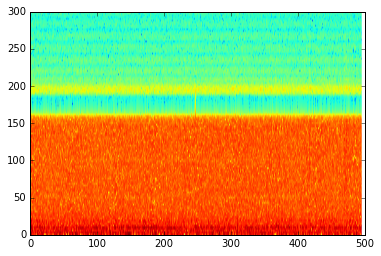

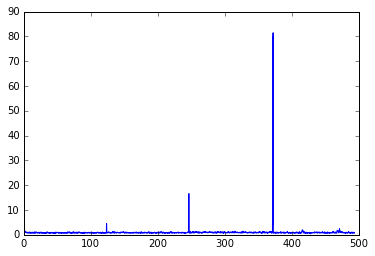

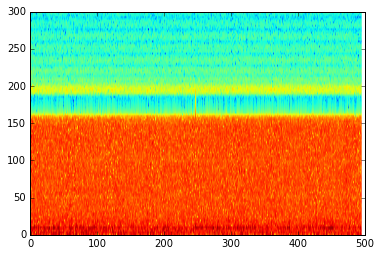

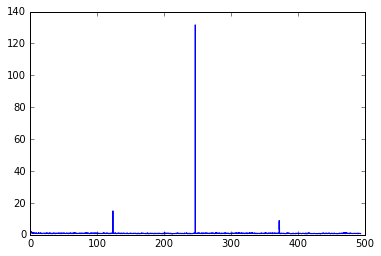

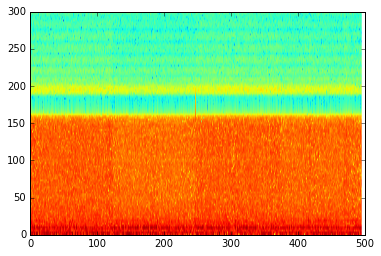

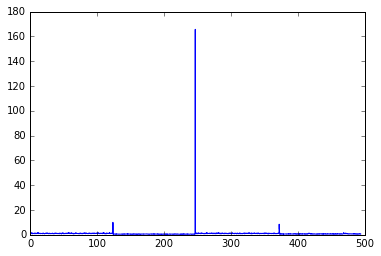

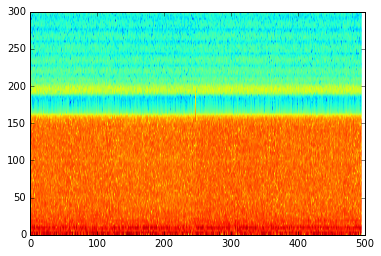

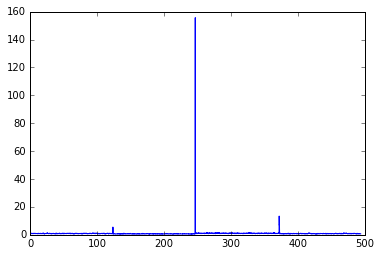

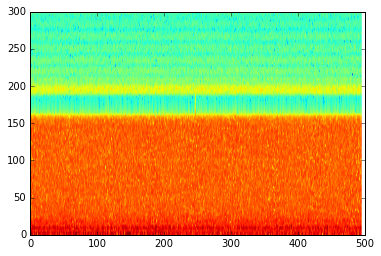

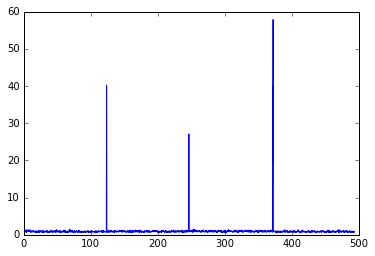

Spectrograms for state samatha


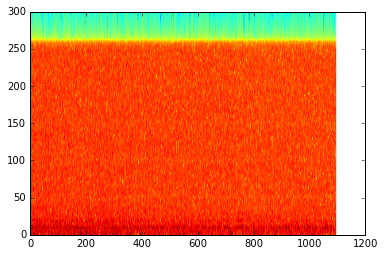

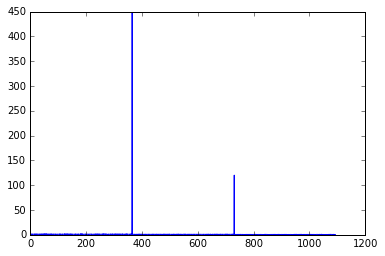

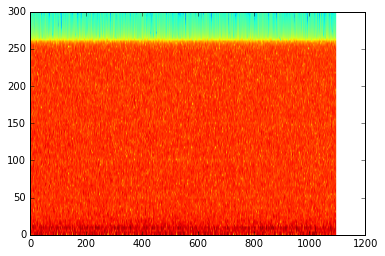

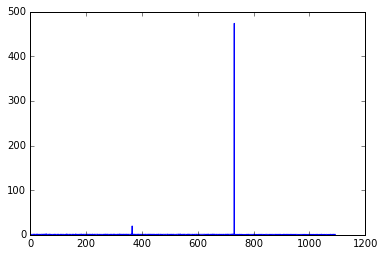

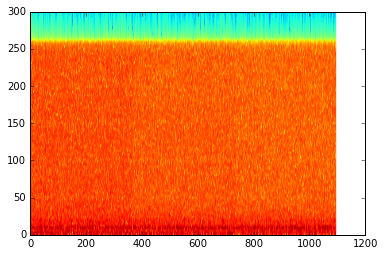

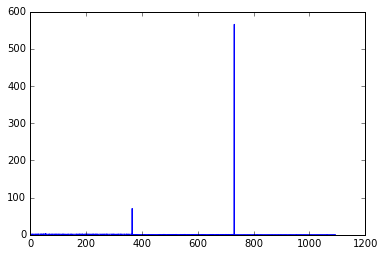

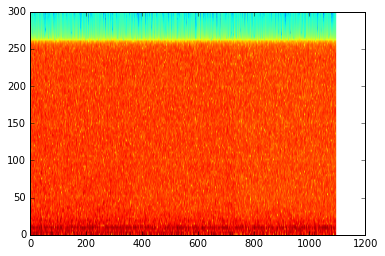

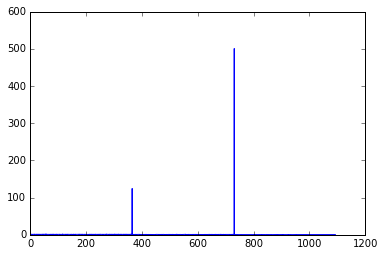

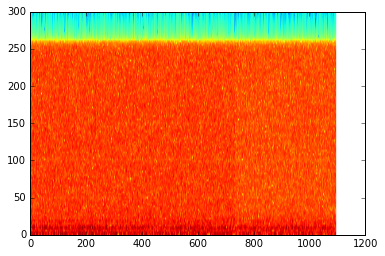

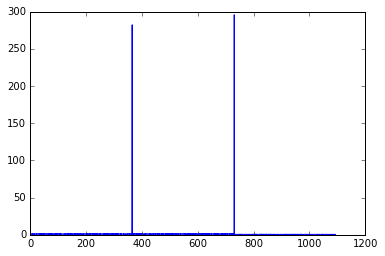

Spectrograms for state vipassana


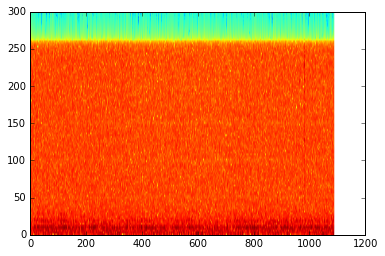

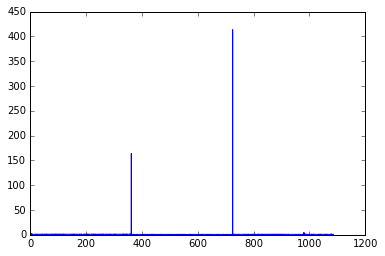

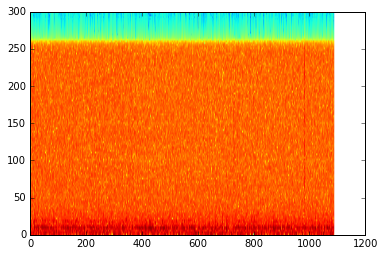

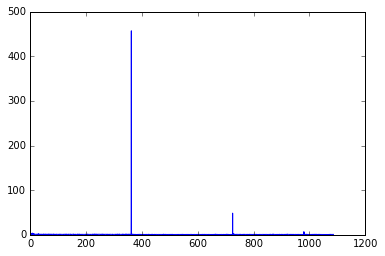

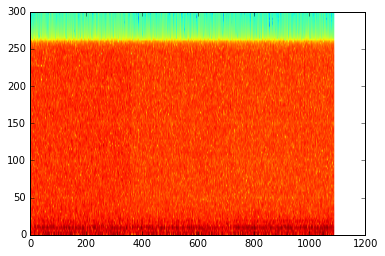

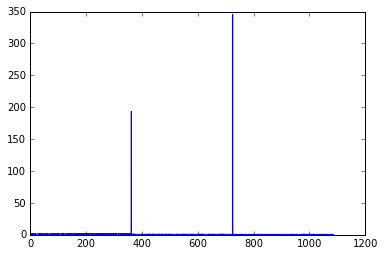

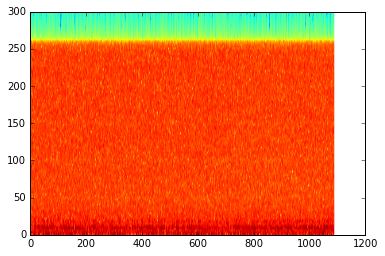

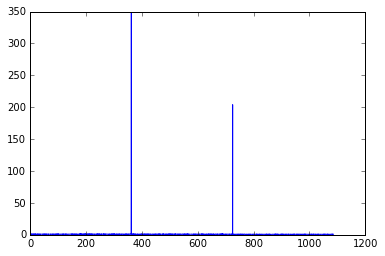

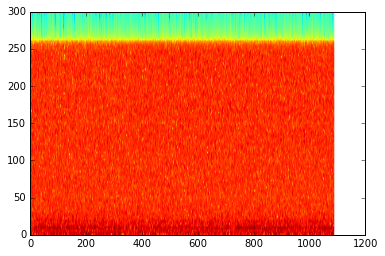

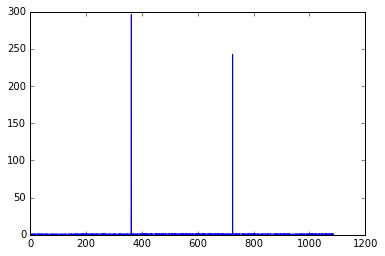

In [87]:
for field in ['rest', 'samatha', 'vipassana']:
    print 'Spectrograms for state %s' % field
    for i in range(5):
        s, fs, ts, _ = plt.specgram(d[field][i,:], Fs=600)
        diff = (numpy.abs(s[:,1:] - s[:,:-1]) / s.mean(axis=1, keepdims=True)).mean(axis=0)
        plt.show()
        plt.plot(ts[:-1], diff)
        plt.show()

## classification using power features

first we build a tensor of size (timesteps x number of sensor x freqs) for each state

In [88]:
features_dict = dict()

for field in ['rest', 'samatha', 'vipassana']:
    print 'Spectrograms for state %s' % field
    features = []
    for i in range(d[field].shape[0]):
        s, fs, ts = mlab.specgram(d[field][i,:], Fs=600)
        features.append(s)
    features_dict[field] = numpy.rollaxis(numpy.array(features), 2)
    print features_dict[field].shape

Spectrograms for state rest
(2314, 148, 129)
Spectrograms for state samatha
(5126, 148, 129)
Spectrograms for state vipassana
(5094, 148, 129)


for each sensor, train a classifier and print its score on a valid set

In [89]:
from sklearn.naive_bayes import GaussianNB

indices = numpy.arange(sum([features_dict[f].shape[0] for f in states]))
numpy.random.shuffle(indices)

targets = numpy.array([0] * features_dict['rest'].shape[0]
                      + [1] * features_dict['samatha'].shape[0]
                      + [2] * features_dict['vipassana'].shape[0])
targets = targets[indices]

train = slice(0, 10000)
test = slice(10000, len(indices))

for sensor in range(features_dict['rest'].shape[1]):
    features = numpy.concatenate([
            features_dict['rest'][:,sensor,:],
            features_dict['samatha'][:,sensor,:],
            features_dict['vipassana'][:,sensor,:],
        ], axis=0)
    
    features = features[indices]
    
    gnb = GaussianNB()
    y_fit = gnb.fit(features[train], targets[train])
    y_pred_train = y_fit.predict(features[train])
    y_pred_test = y_fit.predict(features[test])
    
    print 'Misclassified for sensor %d:' % (sensor, ),
    print float((y_pred_train != targets[train]).sum()) / 10000,
    print float((y_pred_test != targets[test]).sum()) / (test.stop - test.start)

Misclassified for sensor 0: 0.2276 0.226124704025
Misclassified for sensor 1: 0.0023 0.00157853196527
Misclassified for sensor 2: 0.0303 0.0315706393054
Misclassified for sensor 3: 0.0206 0.0205209155485
Misclassified for sensor 4: 0.2515 0.246645619574
Misclassified for sensor 5: 0.1699 0.183109707972
Misclassified for sensor 6: 0.2594 0.260063141279
Misclassified for sensor 7: 0.2708 0.295974743489
Misclassified for sensor 8: 0.0058 0.00473559589582
Misclassified for sensor 9: 0.0033 0.00236779794791
Misclassified for sensor 10: 0.0008 0.00118389897395
Misclassified for sensor 11: 0.0345 0.0299921073402
Misclassified for sensor 12: 0.1362 0.135359116022
Misclassified for sensor 13: 0.2213 0.220994475138
Misclassified for sensor 14: 0.1336 0.136937647987
Misclassified for sensor 15: 0.0033 0.00197316495659
Misclassified for sensor 16: 0.0307 0.0307813733228
Misclassified for sensor 17: 0.0312 0.0382794001579
Misclassified for sensor 18: 0.2706 0.283346487766
Misclassified for sensor 1

# inter monk

load data

In [90]:
d2 = dict()
for field in ['rest', 'samatha', 'vipassana']:
    d1 = loadmat('/data/lisa/data/neuro/Meditation/time-series/cortex/monk02_%s.mat'
                % field)
    d2[field] = d1['F']
    print field, d[field].shape

rest (148, 296419)
samatha (148, 656287)
vipassana (148, 652200)


In [91]:
features_dict2 = dict()

for field in ['rest', 'samatha', 'vipassana']:
    print 'Spectrograms for state %s' % field
    features = []
    for i in range(d[field].shape[0]):
        s, fs, ts = mlab.specgram(d2[field][i,:], Fs=600)
        features.append(s)
    features_dict2[field] = numpy.rollaxis(numpy.array(features), 2)
    print features_dict2[field].shape

Spectrograms for state rest
(3082, 148, 129)
Spectrograms for state samatha
(4966, 148, 129)
Spectrograms for state vipassana
(5033, 148, 129)


In [92]:
targets = numpy.array([0] * features_dict['rest'].shape[0]
                      + [1] * features_dict['samatha'].shape[0]
                      + [2] * features_dict['vipassana'].shape[0])
targets2 = numpy.array([0] * features_dict2['rest'].shape[0]
                      + [1] * features_dict2['samatha'].shape[0]
                      + [2] * features_dict2['vipassana'].shape[0])


for sensor in range(features_dict['rest'].shape[1]):
    features = numpy.concatenate([
            features_dict['rest'][:,sensor,:],
            features_dict['samatha'][:,sensor,:],
            features_dict['vipassana'][:,sensor,:],
        ], axis=0)
    features_test = numpy.concatenate([
        features_dict2['rest'][:,sensor,:],
        features_dict2['samatha'][:,sensor,:],
        features_dict2['vipassana'][:,sensor,:],
    ], axis=0)
    
    gnb = GaussianNB()
    y_fit = gnb.fit(features, targets)
    y_pred_train = y_fit.predict(features)
    y_pred_test = y_fit.predict(features_test)
    
    print 'Misclassified for sensor %d:' % (sensor, ),
    print float((y_pred_train != targets).sum()) / len(targets),
    print float((y_pred_test != targets2).sum()) / len(targets2)

Misclassified for sensor 0: 0.227780437211 0.32505160156
Misclassified for sensor 1: 0.00215414073719 0.381010626099
Misclassified for sensor 2: 0.0299186213499 0.387279259995
Misclassified for sensor 3: 0.0205042284985 0.385597431389
Misclassified for sensor 4: 0.251077070369 0.304105190735
Misclassified for sensor 5: 0.172251475985 0.519226358841
Misclassified for sensor 6: 0.258656454444 0.574573809342
Misclassified for sensor 7: 0.274932184458 0.218408378564
Misclassified for sensor 8: 0.00590394127972 0.658206559132
Misclassified for sensor 9: 0.00311153662039 0.411283541014
Misclassified for sensor 10: 0.000877612892931 0.245164742757
Misclassified for sensor 11: 0.0339077708633 0.338735570675
Misclassified for sensor 12: 0.135391734482 0.425579084168
Misclassified for sensor 13: 0.22155736397 0.38972555615
Misclassified for sensor 14: 0.134194989628 0.415105878755
Misclassified for sensor 15: 0.00303175363013 0.447442856051
Misclassified for sensor 16: 0.030237753311 0.384756517